In [28]:
import pandas as pd
import os
import sys
from torch.utils.data import Dataset, DataLoader
from dataset import DCMImageDataset

pd.set_option('mode.chained_assignment',  None)
data_dir = "../../dataset/rsna-2024-lumbar-spine-degenerative-classification/"

coordinates = pd.read_csv(data_dir + 'train_label_coordinates.csv')
descriptions = pd.read_csv(data_dir + 'train_series_descriptions.csv')
train = pd.read_csv(data_dir + 'train.csv')

d = DCMImageDataset(
	series='Sagittal T1',
	coordinates_file=coordinates,
	descriptions_file=descriptions,
	train_file=train,
	img_dir=data_dir
	)

c:\Users\neo64\AI\deeplearn\rsna2024\dataset.py:54: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.df[self.label_column] = self.df[self.label_column].replace(mapping)


In [29]:
import torch
import torch.nn as nn
from torchsummary import summary
from tqdm.auto import tqdm

In [30]:
print(nn.functional.normalize(d[0][0]))

tensor([[0.0026, 0.0034, 0.0036,  ..., 0.0000, 0.0000, 0.0000],
        [0.0024, 0.0035, 0.0037,  ..., 0.0000, 0.0000, 0.0000],
        [0.0024, 0.0040, 0.0048,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0010, 0.0022, 0.0035,  ..., 0.0000, 0.0000, 0.0000],
        [0.0014, 0.0017, 0.0030,  ..., 0.0000, 0.0000, 0.0000],
        [0.0021, 0.0039, 0.0034,  ..., 0.0000, 0.0000, 0.0000]])


In [31]:
class Model(nn.Module):
    def ConvLayer(self, in_channel, out_channel):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(2)
        )
    
    def FcLayer(self, in_dim, out_dim, bias=True):
        return nn.Sequential(
            nn.Linear(in_features=in_dim, out_features=out_dim, bias=bias),
            nn.ReLU(),
        )

    def __init__(self, output):
        super(Model, self).__init__()
        self.layer1 = self.ConvLayer(1, 32)
        self.layer2 = self.ConvLayer(32, 64)
        self.layer3 = self.ConvLayer(64, 128)
        self.layer4 = self.ConvLayer(128, 256)
        self.layer5 = self.ConvLayer(256, 256)
        
        self.fc1 = self.FcLayer(7* 7* 256, 2048)
        self.fc2 = self.FcLayer(2048, 64)
        self.fc3 = nn.Linear(64, 3* output, bias=False)
        

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.reshape(-1, 7* 7* 256)
        
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [32]:
model = Model(10)
model = model.to('cuda')

In [33]:
lr = 10**-3
optim = torch.optim.Adam(params=model.parameters(), lr=lr)
epoch = 10
loss_fn = nn.CrossEntropyLoss()

In [35]:
len(d)

33670

In [36]:
batch = 256
train_set, val_set = torch.utils.data.random_split(d, [25000, 8670])
train_loader = DataLoader(train_set, batch_size=batch, shuffle=True, num_workers=6, drop_last=True)
test_loader = DataLoader(val_set, batch_size=batch, shuffle=True, num_workers=6, drop_last=True)

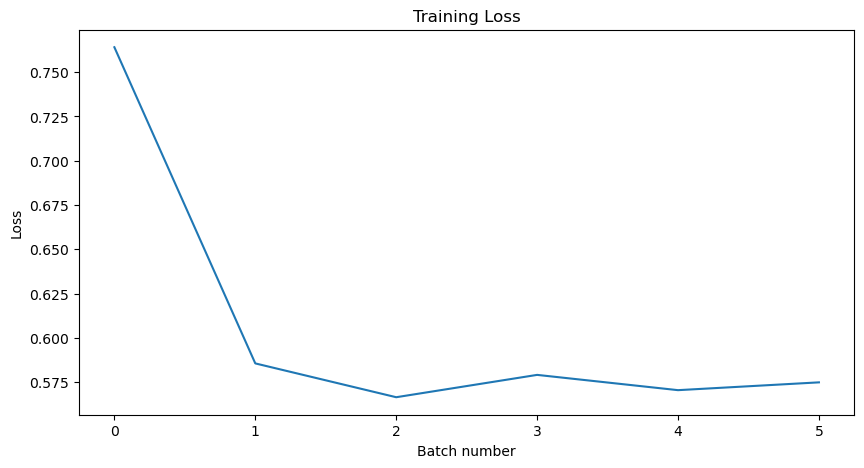

In [37]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

load_path = "weights/Sagittal_t1.pt"
save_path = "weights/Sagittal_t1.pt"
#model.load_state_dict(torch.load(load_path))

losses = []
for epoch_cnt in range(epoch):
    loss_sum = 0

    for i, (input, answer) in enumerate(train_loader):
        optim.zero_grad()

        input = input.to('cuda').unsqueeze(1)
        answer = answer[:, 5:15].type(torch.LongTensor).to('cuda')
        output = model(input).to('cuda')
        output = output.reshape(-1, 3)
        answer = answer.reshape(-1)

        loss = loss_fn(output, answer)
        loss.backward()

        optim.step()
        
        loss_sum += loss.item()
        if i%10==9:
            losses.append(loss_sum / 10)
            loss_sum = 0
            torch.save(model.state_dict(), save_path)
            
            clear_output(wait=True)
            plt.figure(figsize=(10, 5))
            plt.plot(losses)
            plt.xlabel('Batch number')
            plt.ylabel('Loss')
            plt.title('Training Loss')
            plt.show()

    with torch.no_grad():
        total_acc = 0
        for i, (input, answer) in enumerate(test_loader):
            input = input.to('cuda').unsqueeze(1)
            answer = answer[:, 5:15].type(torch.LongTensor).to('cuda')
            output = model(input).to('cuda')
            output = output.reshape(-1, 3)
            answer = answer.reshape(-1)
            output = torch.argmax(output, dim=1)

            acc = torch.sum(output == answer).item() / len(output)
            total_acc += acc

        print(f"acc : {round(total_acc / len(test_loader) * 100, 4)}%")
